In [1]:
from easydict import EasyDict as edict
import numpy as np

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
#tf.disable_v2_behavior()
from generate_network import generate_network as model_fn

test_config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1}, allow_soft_placement=True, log_device_placement=True)
test_config.gpu_options.allow_growth=True 

In [3]:
from generate_data_test_without_blank_depth import input_fn_maker

test_file=['/mnt/sda1/mike/OULU-NPU/One_video_frame', '/mnt/sda1/mike/OULU-NPU/One_video_depth']
test_data_list=[test_file]

eval_input_fn = lambda: input_fn_maker(test_data_list, shuffle=False, 
                                batch_size = 1,
                                epoch=1)

In [4]:
data = input_fn_maker(test_data_list, shuffle=False, 
                                batch_size = 1,
                                epoch=1)

Instructions for updating:
Use output_signature instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [5]:
print(list(data))

['images', 'maps', 'masks', 'labels']


In [6]:
print((data['images'].shape))
print(type(data['images']))
print((data['maps'].shape))
print(type(data['maps']))
print((data['masks'].shape))
print(type(data['masks']))
print((data['labels'].shape))
print(type(data['labels']))

(None, 256, 256, 15)
<class 'tensorflow.python.framework.ops.Tensor'>
(None, 32, 32, 5)
<class 'tensorflow.python.framework.ops.Tensor'>
(None, 32, 32, 5)
<class 'tensorflow.python.framework.ops.Tensor'>
(None, 1)
<class 'tensorflow.python.framework.ops.Tensor'>


In [7]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

#latest_ckp = tf.train.latest_checkpoint('model.ckpt-19501')
print_tensors_in_checkpoint_file(file_name='model.ckpt-19501', tensor_name='', all_tensors=False, all_tensor_names=True)

Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model.ckpt-19501


In [8]:
# GPU config
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True 

#sess = tf.compat.v1.Session(config=config)

# create estimator
this_config=tf.estimator.RunConfig(
    save_summary_steps=10000000000,
    save_checkpoints_steps=None,
    keep_checkpoint_max=1024,
    log_step_count_steps=None,
    session_config=config)

# model fn
model_fn_this=model_fn

# model_dir
inference_model_dir = 'model_github_backup/'

In [9]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=model_fn_this, config=this_config, model_dir=inference_model_dir)

INFO:tensorflow:Using config: {'_model_dir': 'model_github_backup/', '_tf_random_seed': None, '_save_summary_steps': 10000000000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': None, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 1024, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
save_path = "./saved_model/"

feature_spec = {"images": tf.placeholder(dtype=tf.float32, shape=[None, 256, 256, 15], name='images'),
               "maps": tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 5], name='maps'),
               "masks": tf.placeholder(dtype=tf.float32, shape=[None, 256, 256, 15], name='masks'),
               "labels": tf.placeholder(dtype=tf.int32, shape=[None, 1], name='labels')}

input_receiver_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_spec)

mnist_classifier.export_savedmodel(save_path, input_receiver_fn)

Instructions for updating:
This function has been renamed, use `export_saved_model` instead.
INFO:tensorflow:Calling model_fn.
(None, 1)


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


loss_cla  Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(None,), dtype=float32)
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from model_github_backup/model.ckpt-19501
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./saved_model/temp-1618315003/saved_model.pb


b'./saved_model/1618315003'

In [11]:
print(type(data["images"]))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    images_np = data["images"].eval()
    
print(type(images_np))

<class 'tensorflow.python.framework.ops.Tensor'>
Dataset Info:
----------------------------------------
IJCB ijcb_protocal_1 test
File Counts: 1
----------------------------------------
name_pure:  1_1_36_2
<class 'numpy.ndarray'>


In [12]:
features = mnist_classifier.predict(
                input_fn = eval_input_fn,
                checkpoint_path = os.path.join(inference_model_dir, 'model.ckpt-19501'))

In [13]:
feature = list(features)[0]
label = feature['labels']

#print(label.shape)
#print(label)

if label == 0:
    label = 1
else:
    label = 0

labels_onehot = np.eye(2)[label]
#print(logits)
#print(label)
#print(labels_onehot)

label = np.array(label)
label = np.reshape(label,(1,1))
print(label.shape)

INFO:tensorflow:Calling model_fn.
(None, 1)


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


loss_cla  Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(None,), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_github_backup/model.ckpt-19501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Dataset Info:
----------------------------------------
IJCB ijcb_protocal_1 test
File Counts: 1
----------------------------------------
name_pure:  1_1_36_2
(1, 1)


In [14]:
print(tf.__version__)

2.4.1


# 算出來了啦幹!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [14]:
#model_path = "./saved_model/1616739346"
# model_path = "/mnt/sda1/mike/Code/FAS-SGTD/fas_sgtd_multi_frame/saved_model/1617094023"
model_path = './saved_model/1618315003'
with tf.Session(graph=tf.Graph()) as sess:
    meta_graph_def = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_path)
    signature = meta_graph_def.signature_def
    #print(signature)
    x_tensor_name = signature['serving_default'].inputs['images'].name
    label_tensor_name = signature['serving_default'].inputs['labels'].name
    print(x_tensor_name)    
    logit_tensor_name = signature['serving_default'].outputs['logits'].name
    y_tensor_name = signature['serving_default'].outputs['grads'].name
    print(y_tensor_name)
    x = sess.graph.get_tensor_by_name(x_tensor_name)
    y = sess.graph.get_tensor_by_name(y_tensor_name)
    labels = sess.graph.get_tensor_by_name(label_tensor_name)
    logits = sess.graph.get_tensor_by_name(logit_tensor_name)
    
    #print(label.shape)
    
    grads = sess.run(y, {x: images_np, labels: label})
    #print(grads)
    #print(grads.shape)
    
    #print(predictions)
    #print(type(predictions))
    
    #labels_tensor = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
    #logits_tensor = tf.convert_to_tensor(predictions, dtype=tf.float32)
    #print(type(logits_tensor))
    #labels_tensor = tf.expand_dims(labels_tensor,0)
    #print(labels_tensor.shape)
    #print(logits_tensor.shape)
    
    #cross_entropy = tf.losses.softmax_cross_entropy(labels_tensor, logits_tensor)
    #print(cross_entropy)
    #print(cross_entropy.eval())
    
    #grad = tf.gradients(cross_entropy, x)
    #print(grad)
    
    perb = tf.sign(grads)  # calculate perturbation
    #print(perb.eval())
    perturbation = perb.eval()
    print(type(perturbation))
    
    ## Test FGSM ##
    
    original_prediction = sess.run(logits, {x: images_np, labels: label})
    print("original: ", original_prediction)
    
    eps = 0.5
    adv_images = images_np + eps * perturbation
    prediction = sess.run(logits, {x: adv_images})
    print("attack: ", prediction)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from ./saved_model/1618315003/variables/variables
images:0
gradients/FaceMapNet/split_grad/concat:0
<class 'numpy.ndarray'>
original:  [[0.03379667 0.96620333]]
attack:  [[0.5354028 0.4645972]]


In [15]:
#print(images_np)

images_squeeze = np.squeeze(images_np)
frame1, frame2, frame3, frame4, frame5 = np.split(images_squeeze, indices_or_sections=5, axis=2)
print(frame1.shape)

(256, 256, 3)


In [16]:
adv_images_squeeze = np.squeeze(adv_images)
adv_frame1, adv_frame2, adv_frame3, adv_frame4, adv_frame5 = np.split(adv_images_squeeze, indices_or_sections=5, axis=2)
print(adv_frame1.shape)

(256, 256, 3)


In [17]:
from matplotlib import pyplot as plt

plt.imshow(frame1)
plt.title('my picture')
plt.show()

<Figure size 640x480 with 1 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


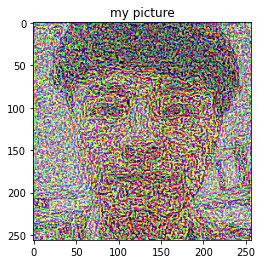

In [18]:
plt.imshow(adv_frame1)
plt.title('my picture')
plt.show()